# Kriging

**Kriging** is a geostatistical interpolation technique that is used to estimate values at unobserved locations based on observed data. It takes into account the spatial correlation between data points to provide more accurate predictions.

This assignment solution focuses on two types of Kriging:

## Ordinary Kriging

_*Ordinary Kriging*_ assumes that the mean of the variable being estimated is unknown and varies spatially.

## Simple Kriging

_*Simple Kriging*_, on the other hand, assumes that the mean is known and constant throughout the study area.

Both _*Ordinary*_ and *_Simple_* *_Kriging_* use __variograms__ to model the spatial correlation and calculate weights for neighboring data points. These weights are then used to estimate values at unobserved locations.

By implementing Kriging techniques, this assignment aims to provide insights into spatial interpolation and the estimation of unknown values based on observed data.

let us import neccessary libraries first ( it is recommended to install packages on a virtual environment as you might need to use this environment frequently for further upcoming assignments, take a look at [**Documentation**](https://docs.python.org/3/library/venv.html) for more information )

In [1]:
import os
root_folder = os.getcwd()

In [2]:
# Create a virtual environment
NAME = "KrigingSolution" # Your virtual environment name
!python -m venv {NAME}
!python -m pip install ipykernel -U -q

Error: [Errno 13] Permission denied: 'c:\\Users\\kpashna\\Documents\\GitHub\\Mineral-Resource-Geology-and-Modelling\\KrigingSolution\\Scripts\\python.exe'


#### Activating virtual environment ( necessary if you want to implement a virtual environment, optional otherwise )
To activate the virtual environment in the Jupyter Notebook and change the kernel to 'tallberg', follow these steps:

- Click on the **"Kernel"** menu at the top right of the Jupyter Notebook.
- Select **"Change Kernel"** from the dropdown menu.
- In the **"Kernel"** submenu, select "tallberg" from the list of available kernels. If you did not find it, click on **"Select another kernel"**, and click **"Python environments"**. Add the root folder of environment manually here.
- Once the kernel is changed to 'tallberg', the virtual environment will be automatically activated.
- You can now execute code cells that rely on the packages installed in the 'tallberg' virtual environment.

* You might be asked for installing packages such as ipykernel

Ignore the codes below and skip installing `venv` if you find it too difficult !

In [3]:
import sys

# Get the path of the current Python executable
python_executable = sys.executable
# Extract the virtual environment path from the executable path
venv_path = python_executable.split('/bin/python')[0]
assert venv_path.endswith(NAME) or sys.base_prefix != sys.prefix , "\n" + "*"*20 + f"\nThe virtual environment path is not correct or the virtual environment {NAME} is not activated.\nPlease make sure that the virtual environment is activated and the kernel is running in the virtual environment.\n" + "*"*20 + "\n"

In [4]:
%pip install -q -q -q --upgrade pip
%pip install -q -q -q --upgrade numpy
%pip install -q -q -q --upgrade matplotlib
%pip install -q -q -q --upgrade matplotlib-scalebar
%pip install -q -q -q --upgrade tabulate
%pip install -q -q -q --upgrade scipy
%pip install -q -q -q --upgrade requests

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import scipy.spatial.distance as distance
import numpy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tabulate import tabulate
import csv,requests,itertools
import matplotlib_scalebar.scalebar as ScaleBar
from io import StringIO

### Datasets

As you might realized, to implement kriging for a solution, data is needed. There are several ways to store and access data through. You can choose later which way suits you, and we want to increase the flexibility and functionality of our code for future use.

One way is to retrieve data from a file, lets say a CSV file( not using `pandas` ):

In [6]:
# Define file name
__filename_csv = r"DataOffline/sample data.csv" # Your file name, change it according to your file name and location
# Read the CSV file
with open(__filename_csv, 'r' , encoding='utf-8-sig') as f:
    reader = csv.reader(f)
    data_csv = list(reader)

'''
Or you can do this instead:
data    =   open( os.path.join( root_folder , 'DataOffline' , 'sample data.csv' ) ,  'r' ).readlines()
data_csv = [ row.strip().split(',') for row in data ] # Or convert it to numpy array
'''
# Convert the data to a list of tuples with float values
colnames_csv , data_csv = data_csv[0] , [tuple(map(float, row)) for row in data_csv[1:]]
print( tabulate(data_csv[:5], headers=colnames_csv , tablefmt='rounded_grid') )

╭─────┬─────┬──────╮
│   X │   Y │   Cu │
├─────┼─────┼──────┤
│   0 │   0 │ 0.29 │
├─────┼─────┼──────┤
│   1 │   0 │ 0.13 │
├─────┼─────┼──────┤
│   2 │   0 │ 0.35 │
├─────┼─────┼──────┤
│   3 │   0 │ 0.13 │
├─────┼─────┼──────┤
│   4 │   0 │ 0.37 │
╰─────┴─────┴──────╯


Another way ( which sometimes become useful specially on small datasets ) is to create lists ( or `DataFrames` in `pandas` ), or `tuple`s manually; there is no rule for formatting, however it is recommended to use `tuple` to make your data immutable and fixed-size, letting the operating system minimize the storage of dataset(s). Numpy resists to this conversion

In [7]:
data_handy  = numpy.array([
    (0, 0, 0.29),
    (1, 0, 0.13),
    (2, 0, 0.35),
    (3, 0, 0.13),
    (4, 0, 0.37)
] ,dtype=[('X', 'f8'), ('Y', 'f8'), ('Cu', 'f8')] )
print( tabulate(data_handy , headers=data_handy.dtype.names ,  tablefmt='rounded_grid' ) ) 
print( type(data_handy[0][2]))

╭─────┬─────┬──────╮
│   X │   Y │   Cu │
├─────┼─────┼──────┤
│   0 │   0 │ 0.29 │
├─────┼─────┼──────┤
│   1 │   0 │ 0.13 │
├─────┼─────┼──────┤
│   2 │   0 │ 0.35 │
├─────┼─────┼──────┤
│   3 │   0 │ 0.13 │
├─────┼─────┼──────┤
│   4 │   0 │ 0.37 │
╰─────┴─────┴──────╯
<class 'numpy.float64'>


Or you can retrieve data from online sources, such as GitHub:

In [8]:
# This function returns the data from the GitHub repository as numpy array.
 
def load_dataset_github( ) -> numpy.array:
    # URL of the raw data file on GitHub
    url = "https://raw.githubusercontent.com/kiarash13p/Mineral-Resource-Geology-and-Modelling/main/Data/Kriging%20Solution/kriging%20solution.csv"
    # Make an HTTP GET request to retrieve the data
    response = requests.get(url)
    response.raise_for_status() # prevent proceeding for invalid requests
    # Read the response into a list format
    data = list( csv.reader( StringIO( response.text.replace('\ufeff', '') ) ) )
    # Convert the data to a numpy array
    return numpy.array( [tuple(i) for i in data[1:]] , dtype=[('ID','U1'),('X', 'f8'), ('Y', 'f8'), ('Cu', 'f8')] )

In [9]:
data_github = load_dataset_github()
print( tabulate(data_github , headers=data_github.dtype.names , tablefmt='rounded_grid') )

╭──────┬─────┬─────┬──────╮
│ ID   │   X │   Y │   Cu │
├──────┼─────┼─────┼──────┤
│ A    │   5 │   3 │ 4.77 │
├──────┼─────┼─────┼──────┤
│ B    │   3 │   6 │ 6.96 │
├──────┼─────┼─────┼──────┤
│ C    │   3 │   2 │ 2.27 │
├──────┼─────┼─────┼──────┤
│ D    │   4 │   9 │ 6.46 │
├──────┼─────┼─────┼──────┤
│ E    │   6 │   9 │ 6.06 │
├──────┼─────┼─────┼──────┤
│ F    │   6 │   8 │ 7.91 │
╰──────┴─────┴─────┴──────╯


And you can navigate through the dataset by rows and columns:

In [10]:
print( data_github['ID'] )
print( tabulate(data_github[2:4] , headers=data_github.dtype.names , tablefmt='rounded_grid') )
print( tabulate(data_github[ data_github['Cu'] > 5.0 ] , headers=data_github.dtype.names , tablefmt='rounded_grid' ) )

['A' 'B' 'C' 'D' 'E' 'F']
╭──────┬─────┬─────┬──────╮
│ ID   │   X │   Y │   Cu │
├──────┼─────┼─────┼──────┤
│ C    │   3 │   2 │ 2.27 │
├──────┼─────┼─────┼──────┤
│ D    │   4 │   9 │ 6.46 │
╰──────┴─────┴─────┴──────╯
╭──────┬─────┬─────┬──────╮
│ ID   │   X │   Y │   Cu │
├──────┼─────┼─────┼──────┤
│ B    │   3 │   6 │ 6.96 │
├──────┼─────┼─────┼──────┤
│ D    │   4 │   9 │ 6.46 │
├──────┼─────┼─────┼──────┤
│ E    │   6 │   9 │ 6.06 │
├──────┼─────┼─────┼──────┤
│ F    │   6 │   8 │ 7.91 │
╰──────┴─────┴─────┴──────╯


## Defining the problem

So simple 😊. We want to find estimates and estimation variances of `targets` points, given the observed value on `data_github` and variogram model, using Simple and/or Ordinary Kriging. To increase the functionality of the code, lets define some functions and preliminary initializations.

In [11]:
targets             =   numpy.array([
    ('T1',5, 4),
    ('T2',6, 4),
    ('T3',4, 7)
    ] , dtype=[('ID','U2'),('X', 'f8'), ('Y', 'f8')])

In [12]:
# Two different ways to print arrays
def printtable( data , headers : str = ""):
    print( tabulate( data , 
                    headers=data.dtype.names if data.dtype.names is not None else headers , 
                    tablefmt='rounded_grid' , 
                    numalign="left" , 
                    floatfmt=".2f" ) )
printarray = lambda numpyarray: numpy.savetxt(sys.stdout, numpyarray, fmt="% .2f" if numpyarray.dtype.kind in 'biufc' else "%s")
getpoints   =   lambda entry: numpy.column_stack((entry['X'],entry['Y']))
METHOD      =   "OK" # You can change this to "UK" or "SK" for Universal Kriging or Simple Kriging
# preliminary check-ups
data       =   data_github # You can change this to data_csv or data_handy to use the other datasets 

assert len(data) != 0 , "The dataset is empty."
assert 'X' in data.dtype.names and 'Y' in data.dtype.names , "The dataset should have at least columns: X and Y."
assert len(data.dtype.names) == 4 , "The dataset should have 3 columns: X, Y, and Cu."
assert len(targets) != 0 , "The targets dataset is empty."
assert len(targets.dtype.names) == 3 , "The targets dataset should have 2 columns: X, and Y."
assert 'X' in targets.dtype.names and 'Y' in targets.dtype.names , "The targets dataset should have at least columns: X and Y."
assert METHOD in ["OK","UK","SK"] , "The method should be one of the following: OK, UK, or SK."

In [13]:
printarray( data)
printarray( targets)
printtable( data )
printtable( targets )

A 5.0 3.0 4.77
B 3.0 6.0 6.96
C 3.0 2.0 2.27
D 4.0 9.0 6.46
E 6.0 9.0 6.06
F 6.0 8.0 7.91
T1 5.0 4.0
T2 6.0 4.0
T3 4.0 7.0
╭──────┬──────┬──────┬──────╮
│ ID   │ X    │ Y    │ Cu   │
├──────┼──────┼──────┼──────┤
│ A    │ 5.00 │ 3.00 │ 4.77 │
├──────┼──────┼──────┼──────┤
│ B    │ 3.00 │ 6.00 │ 6.96 │
├──────┼──────┼──────┼──────┤
│ C    │ 3.00 │ 2.00 │ 2.27 │
├──────┼──────┼──────┼──────┤
│ D    │ 4.00 │ 9.00 │ 6.46 │
├──────┼──────┼──────┼──────┤
│ E    │ 6.00 │ 9.00 │ 6.06 │
├──────┼──────┼──────┼──────┤
│ F    │ 6.00 │ 8.00 │ 7.91 │
╰──────┴──────┴──────┴──────╯
╭──────┬──────┬──────╮
│ ID   │ X    │ Y    │
├──────┼──────┼──────┤
│ T1   │ 5.00 │ 4.00 │
├──────┼──────┼──────┤
│ T2   │ 6.00 │ 4.00 │
├──────┼──────┼──────┤
│ T3   │ 4.00 │ 7.00 │
╰──────┴──────┴──────╯


Let us draw a plot of points we would like to use in our estimation. We assign names to all points here as well:

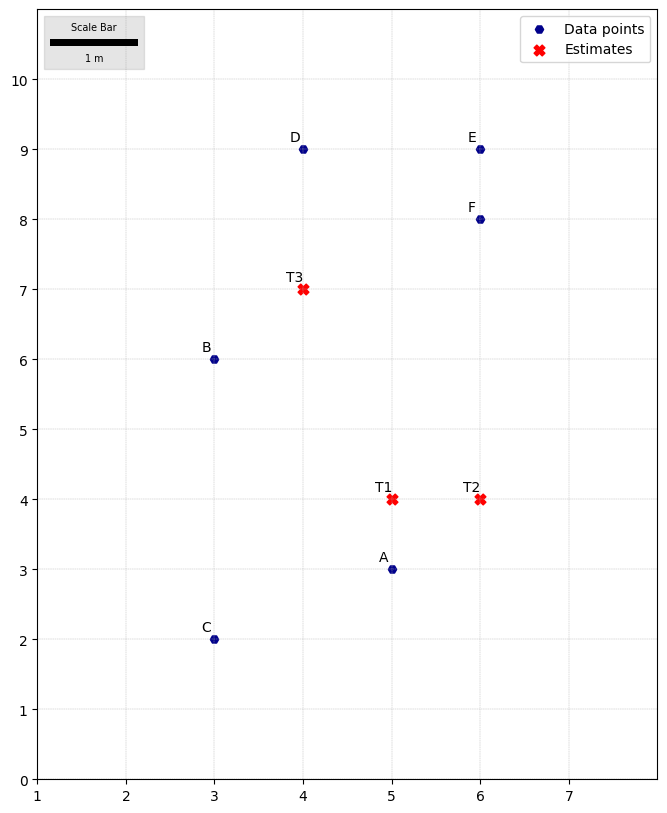

In [14]:
fig1 = plt.figure( figsize=(8,10))
ax1 = fig1.gca()
plt.xlim( min(data['X'] )-2 , max(data['X'] )+2 )
plt.ylim( min(data['Y'] )-2 , max(data['Y'] )+2 )
plt.xticks( numpy.arange( min(data['X'] )-2 , max(data['X'] )+2 , 1 ) )
plt.yticks( numpy.arange( min(data['Y'] )-2 , max(data['Y'] )+2 , 1 ) )
plt.scatter( x=data['X'] , y=data['Y'] , marker='H' , s=35 , c='darkblue' , label = "Data points")
plt.scatter( x=targets['X'] , y=targets['Y'] , marker='X' , s=60 , c='Red' , label = "Estimates")
for row_ in itertools.chain(data,targets):
    plt.annotate(text=row_['ID'] , xy=(row_['X'] , row_['Y']) , xytext=(-6,9) , textcoords='offset points' , horizontalalignment='center', verticalalignment = "center" , fontweight = 'normal')
plt.grid(True , linestyle = '--' , linewidth = 0.3)

# Adding scale bar
scalebar    =   ScaleBar.ScaleBar(1.0 , "m" , 
                                  length_fraction=0.2 , 
                                  location='upper left' , 
                                  label='Scale Bar',
                                  pad=0.4 , 
                                  border_pad=0.5 ,
                                  color='black' ,
                                  box_color='gray' ,
                                  box_alpha=0.2 ,
                                  font_properties={'size': 'x-small'}
                                   )
ax1.add_artist(scalebar)
# fig.axes[0].add_patch(patches.Circle( targets[0], Range , alpha = 0.15))
plt.legend()
plt.show()

## Solution:

### 1. Calculate distance matrices
Given the assumption of variance dependency to distance ( and nothing else ), it is required to calculate distance of points relatively to each other.

Thus, Two matrices we need to find out. `dist` demonstrate the distances between observed points (`data`) and `target_dist` represents distances of unobserved points to `data` points.

Moreover, we initialize the variable `diff` here, which demonstrates the squared Euclidean distance of `Cu` values. we will use this matrix later

In [15]:
# Calculating distance of the points relatively against each other
dist = distance.squareform(distance.pdist( getpoints(data) ) )
diff = distance.squareform(distance.pdist( data['Cu'].reshape(-1,1) , 'sqeuclidean' ) )
print( "*" * 20 , "< matrix of distances >" , "*" * 20)
printarray( dist )
print( "*" * 20 , "< matrix of diff values >" , "*" * 20)
printarray( diff )
print( data['Cu'] )
# Calculating distance of targets relatively to known-value points
targetdist = distance.cdist( getpoints(targets) , getpoints(data) )
print( "\n" , "*" * 20 , "< matrix of target distance >" , "*" * 20)
printtable( targetdist )


******************** < matrix of distances > ********************
 0.00  3.61  2.24  6.08  6.08  5.10
 3.61  0.00  4.00  3.16  4.24  3.61
 2.24  4.00  0.00  7.07  7.62  6.71
 6.08  3.16  7.07  0.00  2.00  2.24
 6.08  4.24  7.62  2.00  0.00  1.00
 5.10  3.61  6.71  2.24  1.00  0.00
******************** < matrix of diff values > ********************
 0.00  4.80  6.25  2.86  1.66  9.86
 4.80  0.00  22.00  0.25  0.81  0.90
 6.25  22.00  0.00  17.56  14.36  31.81
 2.86  0.25  17.56  0.00  0.16  2.10
 1.66  0.81  14.36  0.16  0.00  3.42
 9.86  0.90  31.81  2.10  3.42  0.00
[4.77 6.96 2.27 6.46 6.06 7.91]

 ******************** < matrix of target distance > ********************
╭──────┬──────┬──────┬──────┬──────┬──────╮
│ 1.00 │ 2.83 │ 2.83 │ 5.10 │ 5.10 │ 4.12 │
├──────┼──────┼──────┼──────┼──────┼──────┤
│ 1.41 │ 3.61 │ 3.61 │ 5.39 │ 5.00 │ 4.00 │
├──────┼──────┼──────┼──────┼──────┼──────┤
│ 4.12 │ 1.41 │ 5.10 │ 2.00 │ 2.83 │ 2.24 │
╰──────┴──────┴──────┴──────┴──────┴──────╯


### 2. Plot experimental variogram



In [16]:
stepsize    =   1.0
steptol     =   0.5
steps       =   numpy.arange(0, numpy.ceil(numpy.max(dist)), stepsize)
mean        =       numpy.mean( data['Cu'] ).round(2)
variance    =       numpy.var( data['Cu'] ).round(2)
def gamma( step , tol ):
    selection = numpy.where( (dist >= step - tol) & (dist <= step + tol) , diff , 0.0 ) # you can also use np.select instead of np.where
    sum_ = numpy.sum(selection)
    return sum_ / (2.0* numpy.count_nonzero(selection) ) if numpy.count_nonzero(selection) != 0.0 else 0.0
gammaexpvalues     =   [gamma( i, steptol ) for i in steps]

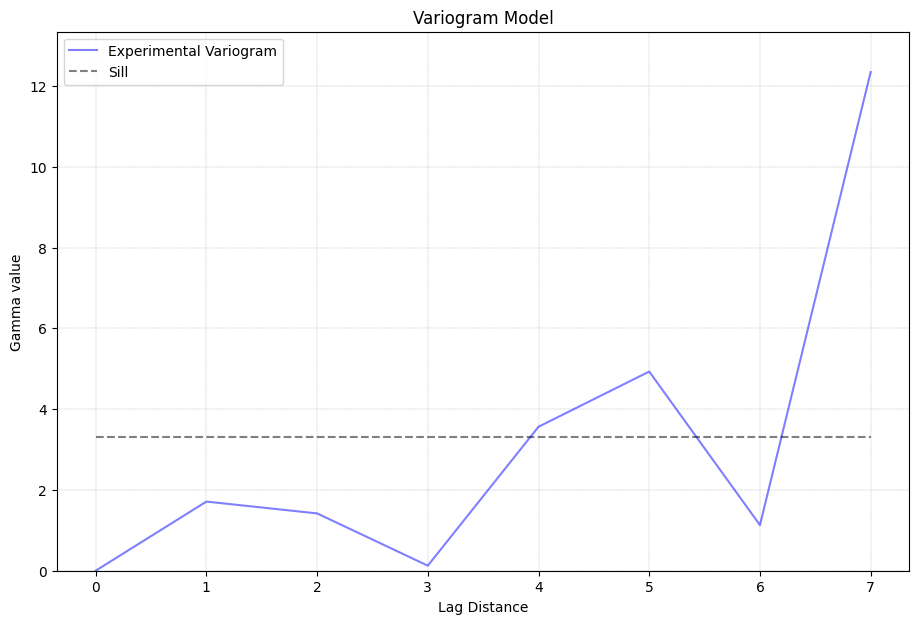

In [17]:
fig2 = plt.figure( figsize=(11,7) )
ax2 = fig2.gca()
ax2.plot(steps, gammaexpvalues, 'b-', label='Experimental Variogram' , alpha=0.5)
ax2.hlines( variance , 0 , numpy.max(steps) , colors='black' , linestyles='dashed' , label='Sill' , alpha=0.5)
ax2.set_xlabel('Lag Distance')
ax2.set_ylabel('Gamma value')
ax2.set_title('Variogram Model')
ax2.grid(True , linestyle = '--' , linewidth = 0.3)
ax2.set_ylim(0, numpy.max(gammaexpvalues) + 1)
ax2.legend()

We need to fit a variogram model to this experimental one.

### 3. Define Variogram model

In order to calculate semivariance and covariance matrices, we need to define the variogram model. Here, we assume that the `sill` equals to `variance` of observed values, `nugget` will be less than 10% of total `variance`.

In [18]:
nugget      =       0.1 * variance
gamma       =       variance - nugget # You should know why we subtract the nugget from the variance , :), if not, ask me.
printtable( numpy.array([['Mean',mean],['Variance',variance],['Nugget',nugget],['Sill',gamma + nugget]] ).T )

╭──────┬──────────┬────────┬──────╮
│ Mean │ Variance │ Nugget │ Sill │
├──────┼──────────┼────────┼──────┤
│ 5.74 │ 3.3      │ 0.33   │ 3.3  │
╰──────┴──────────┴────────┴──────╯


In [19]:
'''
The semivariogram model is used to calculate the semivariance between pairs of points at different distances.
    param h: The distance between the pairs of points
    param _nugget_: The nugget effect
    param _gamma_: The sill
    param _range_: The range
    return: The semivariance between pairs of points at different distances
'''
def semivariogram_model( h , _nugget_ , _gamma_ , _range_ ):
    return numpy.piecewise( h , [ h <= _range_ , h > _range_ ] , [lambda h: _nugget_ + _gamma_ *( 1.5*(h/_range_) - 0.5*(h/_range_)**3), _gamma_ + _nugget_ ] )

# Testing the semivariogram model function with some test cases to ensure its correctness
def test_semivariogram_model():
    # Test case 1
    h1 = 0.0
    nugget1 = 0.1
    sill1 = 1.0
    range1 = 5.0
    expected1 = 0.1
    result1 = semivariogram_model(h1, nugget1, sill1 - nugget1, range1)
    assert numpy.isclose(result1, expected1 , rtol = 0.02 ), f"Test case 1 failed: expected {expected1}, got {result1}"
    
    # Test case 2
    h2 = 100
    nugget2 = 0.2
    sill2 = 2.0
    range2 = 10.0
    expected2 = 2.0
    result2 = semivariogram_model(h2, nugget2, sill2 - nugget2, range2)
    assert numpy.isclose(result2, expected2 , rtol = 0.02 ), f"Test case 2 failed: expected {expected2}, got {result2}"
    
    # Test case 3
    h3 =  5.0
    nugget3 = 0.05
    sill3 = 1.0
    range3 = 8
    expected3 = 0.825
    result3 = semivariogram_model(h3, nugget3, sill3 - nugget3, range3)
    assert numpy.isclose(result3, expected3 , rtol = 0.02 ), f"Test case 3 failed: expected {expected3}, got {result3}"
    
    print("All test cases passed!")
test_semivariogram_model()


All test cases passed!


We define a temporary function here, `gammavalues` which receives a distance value and a `Range` to calculate gamma values.

**Change the `Range` value to find the best fit**

In [20]:
gammavalues     =   numpy.vectorize( lambda x,y: semivariogram_model( x , nugget , gamma , y ) )
Range           =   4.0 # < YOUR RANGE VALUE >


Let's plot the variogram model against the experimental!

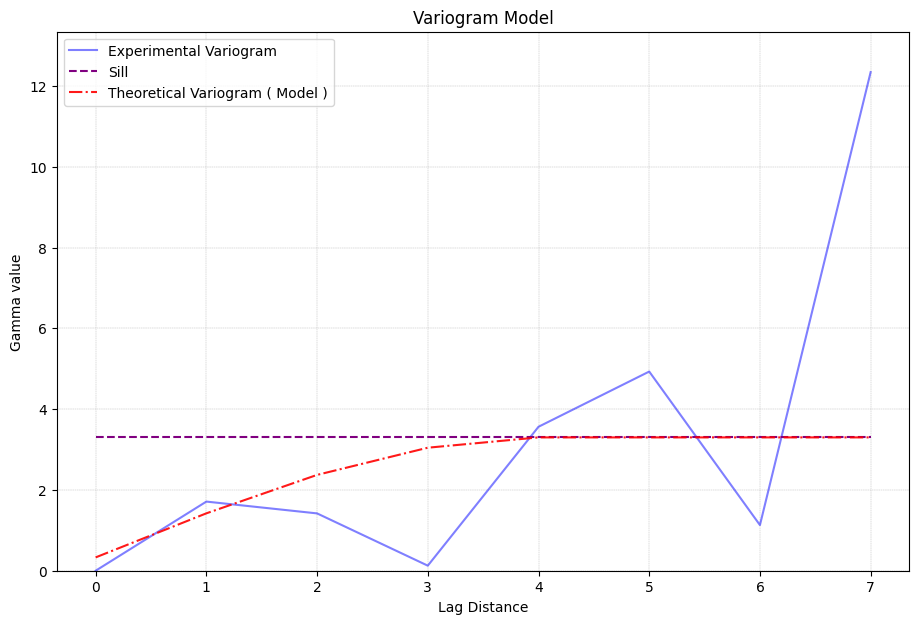

In [21]:
fig2 = plt.figure( figsize=(11,7) )
ax2 = fig2.gca()
ax2.plot(steps, gammaexpvalues, 'b-', label='Experimental Variogram' , alpha=0.5 )
ax2.hlines( variance , 0 , numpy.max(steps) , colors='purple' , linestyles='dashed' , label='Sill' , alpha=1.0 )
ax2.plot(steps, gammavalues( steps , Range ) , 'r-.' , label='Theoretical Variogram ( Model )' , alpha=0.9 )
ax2.legend()
ax2.set_xlabel('Lag Distance')
ax2.set_ylabel('Gamma value')
ax2.set_title('Variogram Model')
ax2.grid(True , linestyle = '--' , linewidth = 0.3)
ax2.set_ylim(0, numpy.max(gammaexpvalues) + 1)
plt.show()

You can plot the range of model on one of the estimate points to make a sense of the range you have chosen already.

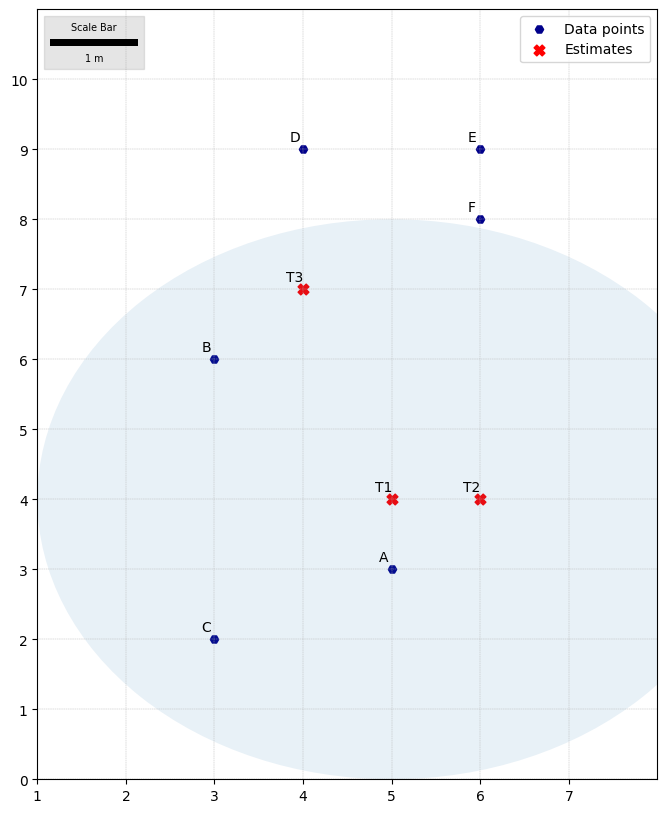

In [22]:
fig1 = plt.figure( figsize=(8,10))
ax1 = fig1.gca()
plt.xlim( min(data['X'] )-2 , max(data['X'] )+2 )
plt.ylim( min(data['Y'] )-2 , max(data['Y'] )+2 )
plt.xticks( numpy.arange( min(data['X'] )-2 , max(data['X'] )+2 , 1 ) )
plt.yticks( numpy.arange( min(data['Y'] )-2 , max(data['Y'] )+2 , 1 ) )
plt.scatter( x=data['X'] , y=data['Y'] , marker='H' , s=35 , c='darkblue' , label = "Data points")
plt.scatter( x=targets['X'] , y=targets['Y'] , marker='X' , s=60 , c='Red' , label = "Estimates")
for row_ in itertools.chain(data,targets):
    plt.annotate(text=row_['ID'] , xy=(row_['X'] , row_['Y']) , xytext=(-6,9) , textcoords='offset points' , horizontalalignment='center', verticalalignment = "center" , fontweight = 'normal')
plt.grid(True , linestyle = '--' , linewidth = 0.3)

# Adding scale bar
scalebar    =   ScaleBar.ScaleBar(1.0 , "m" , 
                                  length_fraction=0.2 , 
                                  location='upper left' , 
                                  label='Scale Bar',
                                  pad=0.4 , 
                                  border_pad=0.5 ,
                                  color='black' ,
                                  box_color='gray' ,
                                  box_alpha=0.2 ,
                                  font_properties={'size': 'x-small'}
                                   )
ax1.add_artist(scalebar)
ax1.add_patch(patches.Circle( getpoints(targets)[0], Range , alpha = 0.1) )
plt.legend()
plt.show()

On this assignment, we assume that search ellipsoid is as same as variogram model.

### 4. Calculate variance/covariance matrices

It is time to find our correlations between points, then initializing `K` and `k` matrices.

Variance matrices are as follows (`semivariance_matrix` and `semivariance_matrix_target`):

In [23]:
# Calculating gamma values of samples against each other
semivariance_matrix = semivariogram_model( dist , nugget , gamma , Range )
print( "Matrix of semivariance :")
printarray( semivariance_matrix  )

# Calculating gamma values of samples against estimate points
semivariance_matrix_target = semivariogram_model( targetdist , nugget , gamma , Range )
print( "\nMatrix of semivariance ( target ) :"  )
printtable( semivariance_matrix_target )

Matrix of semivariance :
 0.33  3.26  2.56  3.30  3.30  3.30
 3.26  0.33  3.30  3.12  3.30  3.26
 2.56  3.30  0.33  3.30  3.30  3.30
 3.30  3.12  3.30  0.33  2.37  2.56
 3.30  3.30  3.30  2.37  0.33  1.42
 3.30  3.26  3.30  2.56  1.42  0.33

Matrix of semivariance ( target ) :
╭──────┬──────┬──────┬──────┬──────┬──────╮
│ 1.42 │ 2.96 │ 2.96 │ 3.30 │ 3.30 │ 3.30 │
├──────┼──────┼──────┼──────┼──────┼──────┤
│ 1.84 │ 3.26 │ 3.26 │ 3.30 │ 3.30 │ 3.30 │
├──────┼──────┼──────┼──────┼──────┼──────┤
│ 3.30 │ 1.84 │ 3.30 │ 2.37 │ 2.96 │ 2.56 │
╰──────┴──────┴──────┴──────┴──────┴──────╯


And consequently, Covariances are `covariance_matrix` and `covariance_matrix_target`:

In [24]:
# Calculating both covariance matrixes bu substracting from the 'sill'
covariance_matrix = (nugget + gamma) - semivariance_matrix
print( "Covariance matrix:" )
printarray(covariance_matrix)
covariance_matrix_target = (nugget + gamma) - semivariance_matrix_target
print( "\nCovariance matrix target:" )
printtable(covariance_matrix_target)

Covariance matrix:
 2.97  0.04  0.74  0.00  0.00  0.00
 0.04  2.97  0.00  0.18  0.00  0.04
 0.74  0.00  2.97  0.00  0.00  0.00
 0.00  0.18  0.00  2.97  0.93  0.74
 0.00  0.00  0.00  0.93  2.97  1.88
 0.00  0.04  0.00  0.74  1.88  2.97

Covariance matrix target:
╭──────┬──────┬──────┬──────┬──────┬──────╮
│ 1.88 │ 0.34 │ 0.34 │ 0.00 │ 0.00 │ 0.00 │
├──────┼──────┼──────┼──────┼──────┼──────┤
│ 1.46 │ 0.04 │ 0.04 │ 0.00 │ 0.00 │ 0.00 │
├──────┼──────┼──────┼──────┼──────┼──────┤
│ 0.00 │ 1.46 │ 0.00 │ 0.93 │ 0.34 │ 0.74 │
╰──────┴──────┴──────┴──────┴──────┴──────╯


### 5. Calculate _*`K`*_ and _*`k`*_ matrices

Hereby, by knowing the covariances, _**K**_ and _**k**_ can be calculated. Here, We need to consider the Kriging type, whether it is __Ordinary__ or __Simple__.

In [25]:
# Since the relative distances of samples are same against each other for all targets, matrix 'K' would be constant for all solutions
if METHOD == "OK":
    K = numpy.vstack( ( numpy.hstack( ( covariance_matrix , numpy.ones( (data.shape[0] , 1 ) ) ) ) , numpy.ones( (1 , data.shape[0]+1 ) ) ) )
    K[ -1 , -1 ] = 0
    k = numpy.hstack( ( covariance_matrix_target , numpy.ones( (len(targets),1) ) ) )
else: # In simple kriging, the matrices would be the same as the covariance matrices
    K = covariance_matrix
    k = covariance_matrix_target
print( "K matrix:" )
printarray(K)
print( "\nk matrix:" )
printtable(k)

K matrix:
 2.97  0.04  0.74  0.00  0.00  0.00  1.00
 0.04  2.97  0.00  0.18  0.00  0.04  1.00
 0.74  0.00  2.97  0.00  0.00  0.00  1.00
 0.00  0.18  0.00  2.97  0.93  0.74  1.00
 0.00  0.00  0.00  0.93  2.97  1.88  1.00
 0.00  0.04  0.00  0.74  1.88  2.97  1.00
 1.00  1.00  1.00  1.00  1.00  1.00  0.00

k matrix:
╭──────┬──────┬──────┬──────┬──────┬──────┬──────╮
│ 1.88 │ 0.34 │ 0.34 │ 0.00 │ 0.00 │ 0.00 │ 1.00 │
├──────┼──────┼──────┼──────┼──────┼──────┼──────┤
│ 1.46 │ 0.04 │ 0.04 │ 0.00 │ 0.00 │ 0.00 │ 1.00 │
├──────┼──────┼──────┼──────┼──────┼──────┼──────┤
│ 0.00 │ 1.46 │ 0.00 │ 0.93 │ 0.34 │ 0.74 │ 1.00 │
╰──────┴──────┴──────┴──────┴──────┴──────┴──────╯


And the inversed matrix, _**K<sup>-1</sup>**_ ( `K_inv` ) will be:

In [26]:
# Calculatig Inversed matrix of 'K'
K_inv = numpy.linalg.inv( K )
print ( "Inversed K :" )
printarray(K_inv)

Inversed K :
 0.31 -0.06 -0.14 -0.04 -0.03 -0.03  0.19
-0.06  0.27 -0.06 -0.07 -0.02 -0.05  0.22
-0.14 -0.06  0.31 -0.04 -0.03 -0.03  0.19
-0.04 -0.07 -0.04  0.34 -0.12 -0.06  0.16
-0.03 -0.02 -0.03 -0.12  0.57 -0.37  0.11
-0.03 -0.05 -0.03 -0.06 -0.37  0.54  0.13
 0.19  0.22  0.19  0.16  0.11  0.13 -0.71


It is time to calculate landas, __**$\lambda$**__ :

In [32]:
Landas = (k@K_inv)
printtable( Landas)


╭──────┬──────┬───────┬──────┬───────┬──────┬───────╮
│ 0.70 │ 0.17 │ 0.01  │ 0.04 │ 0.04  │ 0.04 │ -0.21 │
├──────┼──────┼───────┼──────┼───────┼──────┼───────┤
│ 0.63 │ 0.14 │ -0.00 │ 0.09 │ 0.06  │ 0.07 │ -0.42 │
├──────┼──────┼───────┼──────┼───────┼──────┼───────┤
│ 0.02 │ 0.50 │ 0.03  │ 0.28 │ -0.11 │ 0.28 │ -0.10 │
╰──────┴──────┴───────┴──────┴───────┴──────┴───────╯


In [33]:
_targets    =   targets.reshape(len(targets),1)
_targets    =   [list(*i) for i in _targets]
weights     =   numpy.hstack( ( _targets , Landas ) )
printtable( weights , headers=itertools.chain(["Point Names \ Loc + Datapoint Names ","X","Y"],data['ID'],'μ' if METHOD == "OK" else None) )

╭────────────────────────────────────────┬──────┬──────┬──────┬──────┬───────┬──────┬───────┬──────┬───────╮
│ Point Names \ Loc + Datapoint Names    │ X    │ Y    │ A    │ B    │ C     │ D    │ E     │ F    │ μ     │
├────────────────────────────────────────┼──────┼──────┼──────┼──────┼───────┼──────┼───────┼──────┼───────┤
│ T1                                     │ 5.00 │ 4.00 │ 0.70 │ 0.17 │ 0.01  │ 0.04 │ 0.04  │ 0.04 │ -0.21 │
├────────────────────────────────────────┼──────┼──────┼──────┼──────┼───────┼──────┼───────┼──────┼───────┤
│ T2                                     │ 6.00 │ 4.00 │ 0.63 │ 0.14 │ -0.00 │ 0.09 │ 0.06  │ 0.07 │ -0.42 │
├────────────────────────────────────────┼──────┼──────┼──────┼──────┼───────┼──────┼───────┼──────┼───────┤
│ T3                                     │ 4.00 │ 7.00 │ 0.02 │ 0.50 │ 0.03  │ 0.28 │ -0.11 │ 0.28 │ -0.10 │
╰────────────────────────────────────────┴──────┴──────┴──────┴──────┴───────┴──────┴───────┴──────┴───────╯


In [59]:
# Calculating estimates and associated variance(s)
if METHOD == "OK":
    Estimation      =   Landas[:,:-1]@data['Cu'] # Okey
    print( k[:,:-1].shape ,  Landas[:,:-1].T.shape , Landas[:,-1].shape )
    EstVariance     =   Landas[:,:-1].T@k[:,:-1] - Landas[:,-1]
else:
    Estimation = Landas@data[:,2]
    EstVariance = sill - Landas@k[0]
printarray( Estimation )
printarray( EstVariance)

(3, 6) (6, 3) (3,)


ValueError: operands could not be broadcast together with shapes (6,6) (3,) 

#### Later: plot of points vs estimated points + decorations $ \lambda + \mu + tables$